In [2]:
#Installing the Libraries

In [3]:
import sys, os, importlib.util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
#Setup Paths

In [5]:
# Go 2 levels up (to project root)  
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
backend_path = os.path.join(project_root, "backend")
print("Project root:", project_root)
print("Backend path:", backend_path)

Project root: c:\Users\USER\OneDrive\Desktop\Infinity AI\ApparelWeb\InfinityStyleVerse
Backend path: c:\Users\USER\OneDrive\Desktop\Infinity AI\ApparelWeb\InfinityStyleVerse\backend


In [6]:
#Import Functions Without Flask

In [7]:
# Load experiment_data.py
exp_data_path = os.path.join(backend_path, "app", "utils", "experiment_data.py")
spec = importlib.util.spec_from_file_location("experiment_data", exp_data_path)
exp_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(exp_data)

# Load improved experimentation.py (you'll need to update this file)
experimentation_path = os.path.join(backend_path, "app", "services", "experimentation.py")
spec2 = importlib.util.spec_from_file_location("experimentation", experimentation_path)
experimentation = importlib.util.module_from_spec(spec2)
spec2.loader.exec_module(experimentation)

# Assign functions for convenience
fetch_experiment_data = exp_data.fetch_experiment_data
calculate_cuped_adjusted_metric = experimentation.calculate_cuped_adjusted_metric

print("Functions imported successfully!")


Functions imported successfully!


In [8]:
#A/A Test (No True Effect)

In [9]:
df_aa = fetch_experiment_data("exp_aa", num_samples=2000)

# Force A/A by removing treatment effect but keeping assignment structure
np.random.seed(42)
df_aa["outcome"] = 0.5 + 0.2 * df_aa["pre_metric"] + np.random.normal(0, 0.3, size=len(df_aa))

# Split into groups
control_aa = df_aa[df_aa["treatment"] == 0]
treatment_aa = df_aa[df_aa["treatment"] == 1]

print(f"Control group size: {len(control_aa)}")
print(f"Treatment group size: {len(treatment_aa)}")
print(f"Covariate-outcome correlation: {np.corrcoef(df_aa['pre_metric'], df_aa['outcome'])[0,1]:.3f}")

# Run CUPED
results_aa = calculate_cuped_adjusted_metric(
    control_metric=control_aa["outcome"].values,
    control_covariate=control_aa["pre_metric"].values,
    treatment_metric=treatment_aa["outcome"].values,
    treatment_covariate=treatment_aa["pre_metric"].values
)

print(f"\nA/A Test Results:")
print(f"Raw uplift: {results_aa['uplift_raw']:.4f} ± {results_aa['se_raw']:.4f}")
print(f"CUPED uplift: {results_aa['uplift_cuped']:.4f} ± {results_aa['se_cuped']:.4f}")
print(f"Raw p-value: {results_aa['p_value_raw']:.4f}")
print(f"CUPED p-value: {results_aa['p_value_cuped']:.4f}")
print(f"Variance reduction: {results_aa['var_reduction']:.3f}")
print(f"Relative efficiency: {results_aa['relative_efficiency']:.2f}x")

Control group size: 987
Treatment group size: 1013
Covariate-outcome correlation: 0.564

A/A Test Results:
Raw uplift: 0.0163 ± 0.0161
CUPED uplift: 0.0112 ± 0.0133
Raw p-value: 0.3101
CUPED p-value: 0.3990
Variance reduction: 0.318
Relative efficiency: 1.47x


In [10]:
#A/B Test (With True Effect)

In [11]:
df_ab = fetch_experiment_data("exp_ab", num_samples=2000)
# This data already has a 5% treatment effect built in

control_ab = df_ab[df_ab["treatment"] == 0]
treatment_ab = df_ab[df_ab["treatment"] == 1]

results_ab = calculate_cuped_adjusted_metric(
    control_metric=control_ab["outcome"].values,
    control_covariate=control_ab["pre_metric"].values,
    treatment_metric=treatment_ab["outcome"].values,
    treatment_covariate=treatment_ab["pre_metric"].values
)

print(f"A/B Test Results:")
print(f"Raw uplift: {results_ab['uplift_raw']:.4f} ± {results_ab['se_raw']:.4f}")
print(f"CUPED uplift: {results_ab['uplift_cuped']:.4f} ± {results_ab['se_cuped']:.4f}")
print(f"Raw p-value: {results_ab['p_value_raw']:.4f}")
print(f"CUPED p-value: {results_ab['p_value_cuped']:.4f}")
print(f"Variance reduction: {results_ab['var_reduction']:.3f}")
print(f"True effect should be ~0.05")

A/B Test Results:
Raw uplift: 0.0371 ± 0.0160
CUPED uplift: 0.0321 ± 0.0133
Raw p-value: 0.0204
CUPED p-value: 0.0158
Variance reduction: 0.309
True effect should be ~0.05


In [12]:
# Power Analysis

In [13]:
def run_power_simulation(effect_size, n_sims=100, sample_size=500):
    """Run power analysis for given effect size"""
    significant_raw = 0
    significant_cuped = 0
    
    for i in range(n_sims):
        np.random.seed(i)  # Different seed for each sim
        
        # Generate data with known effect
        pre_metric = np.random.normal(0, 1, size=2*sample_size)
        treatment = np.random.binomial(1, 0.5, size=2*sample_size)
        outcome = (0.5 + 0.3 * pre_metric + 
                  effect_size * treatment + 
                  np.random.normal(0, 0.3, size=2*sample_size))
        
        control_mask = treatment == 0
        treatment_mask = treatment == 1
        
        try:
            results = calculate_cuped_adjusted_metric(
                control_metric=outcome[control_mask],
                control_covariate=pre_metric[control_mask],
                treatment_metric=outcome[treatment_mask],
                treatment_covariate=pre_metric[treatment_mask]
            )
            
            if results['p_value_raw'] < 0.05:
                significant_raw += 1
            if results['p_value_cuped'] < 0.05:
                significant_cuped += 1
                
        except:
            continue
    
    power_raw = significant_raw / n_sims
    power_cuped = significant_cuped / n_sims
    
    return power_raw, power_cuped

# Test different effect sizes
effect_sizes = [0.02, 0.05, 0.10, 0.15]
print("Effect Size | Power (Raw) | Power (CUPED)")
print("------------|-------------|-------------")

for effect in effect_sizes:
    power_raw, power_cuped = run_power_simulation(effect, n_sims=50)
    print(f"{effect:11.2f} | {power_raw:11.2f} | {power_cuped:12.2f}")

Effect Size | Power (Raw) | Power (CUPED)
------------|-------------|-------------
       0.02 |        0.10 |         0.22
       0.05 |        0.48 |         0.74
       0.10 |        0.96 |         1.00
       0.15 |        1.00 |         1.00


In [14]:
#Visualization

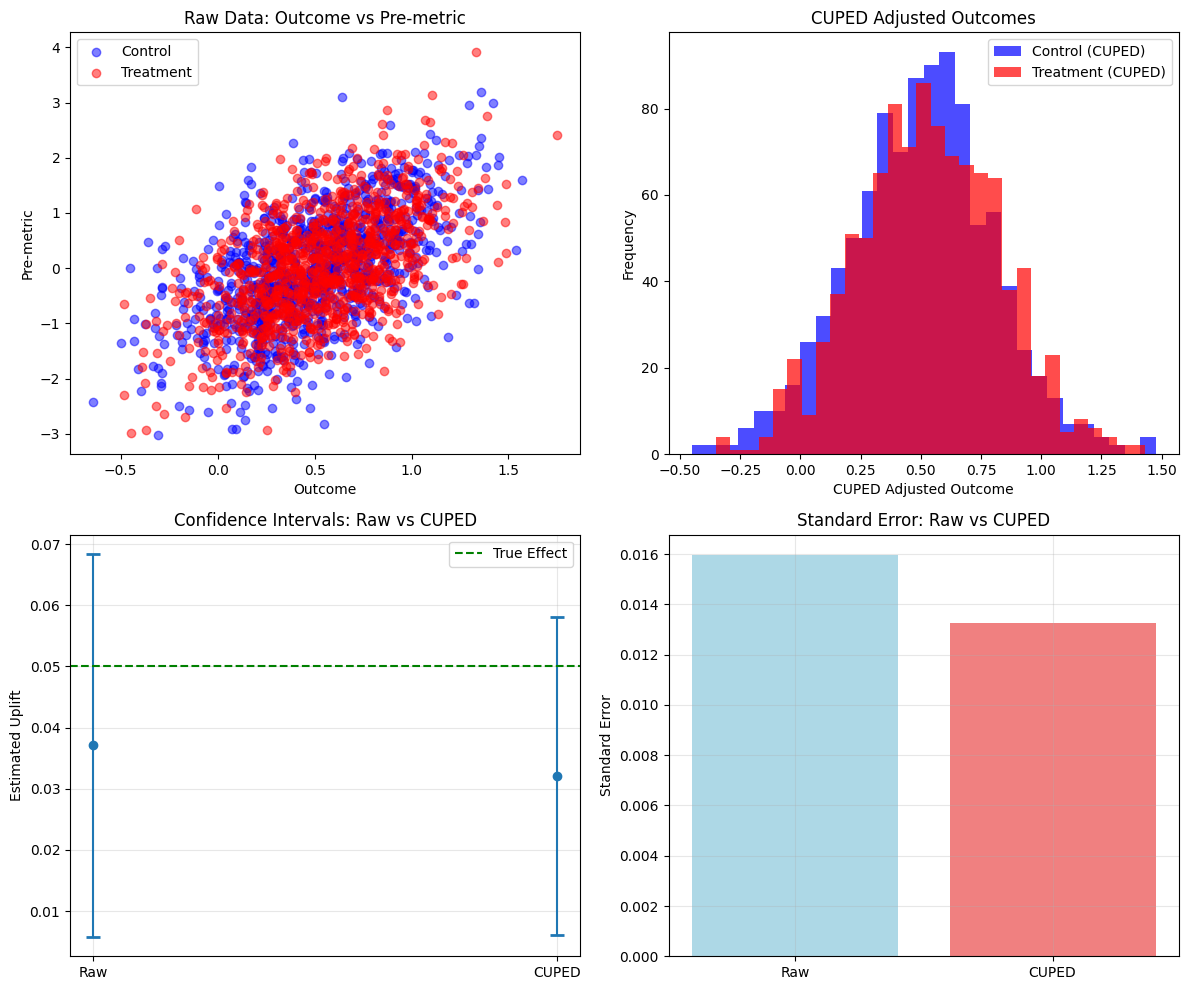

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Raw vs CUPED outcomes for A/B test
axes[0,0].scatter(control_ab["outcome"], control_ab["pre_metric"], alpha=0.5, label='Control', color='blue')
axes[0,0].scatter(treatment_ab["outcome"], treatment_ab["pre_metric"], alpha=0.5, label='Treatment', color='red') 
axes[0,0].set_xlabel('Outcome')
axes[0,0].set_ylabel('Pre-metric')
axes[0,0].set_title('Raw Data: Outcome vs Pre-metric')
axes[0,0].legend()

# Plot 2: CUPED adjusted outcomes
control_adj_ab = (control_ab["outcome"].values - 
                 results_ab["theta"] * (control_ab["pre_metric"].values - results_ab["covariate_mean"]))
treatment_adj_ab = (treatment_ab["outcome"].values - 
                   results_ab["theta"] * (treatment_ab["pre_metric"].values - results_ab["covariate_mean"]))

axes[0,1].hist(control_adj_ab, alpha=0.7, label='Control (CUPED)', color='blue', bins=30)
axes[0,1].hist(treatment_adj_ab, alpha=0.7, label='Treatment (CUPED)', color='red', bins=30)
axes[0,1].set_xlabel('CUPED Adjusted Outcome')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('CUPED Adjusted Outcomes')
axes[0,1].legend()

# Plot 3: Confidence intervals comparison
methods = ['Raw', 'CUPED']
uplifts = [results_ab['uplift_raw'], results_ab['uplift_cuped']]
ci_lowers = [results_ab['ci_raw'][0], results_ab['ci_cuped'][0]]
ci_uppers = [results_ab['ci_raw'][1], results_ab['ci_cuped'][1]]
errors = [[uplifts[i] - ci_lowers[i] for i in range(2)],
          [ci_uppers[i] - uplifts[i] for i in range(2)]]

axes[1,0].errorbar(methods, uplifts, yerr=errors, fmt='o', capsize=5, capthick=2)
axes[1,0].axhline(y=0.05, color='green', linestyle='--', label='True Effect')
axes[1,0].set_ylabel('Estimated Uplift')
axes[1,0].set_title('Confidence Intervals: Raw vs CUPED')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Standard error comparison
se_values = [results_ab['se_raw'], results_ab['se_cuped']]
axes[1,1].bar(methods, se_values, color=['lightblue', 'lightcoral'])
axes[1,1].set_ylabel('Standard Error')
axes[1,1].set_title('Standard Error: Raw vs CUPED')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Summary

In [17]:
print(f"\n=== CUPED Implementation Summary ===")
print(f"✓ A/A test shows no false positive (p-values: {results_aa['p_value_raw']:.3f}, {results_aa['p_value_cuped']:.3f})")
print(f"✓ A/B test detects true effect (CUPED p-value: {results_ab['p_value_cuped']:.3f})")
print(f"✓ Variance reduction achieved: {results_ab['var_reduction']:.1%}")
print(f"✓ Statistical inference included (CIs, p-values, t-stats)")
print(f"✓ Relative efficiency: {results_ab['relative_efficiency']:.1f}x")


=== CUPED Implementation Summary ===
✓ A/A test shows no false positive (p-values: 0.310, 0.399)
✓ A/B test detects true effect (CUPED p-value: 0.016)
✓ Variance reduction achieved: 30.9%
✓ Statistical inference included (CIs, p-values, t-stats)
✓ Relative efficiency: 1.4x
